# Building a rasterizer for 3D meshes

In [266]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial.transform import Rotation as R
import rasterio
from rasterio.plot import show

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['text.usetex'] = True

## Implementing a Z-buffer

The Z-buffer offers a linear-time solution to solving the problem of point occlusion. The idea is first to establish a transformation between coordinate space and buffer indices. We will assume that the original data consist of arbitrary real-valued points in three dimensions, while the buffer is indexed by non-negative integers. In order to convert to buffer coordinates

In [276]:
class Z_Buffer:
    
    def __init__(self, left, right, bottom, top, buffer_width, buffer_height):   
        self.buffer = np.full((buffer_height, buffer_width), -np.inf)
        self.lookup = np.zeros((buffer_height, buffer_width))
        self.image_size = np.array([top-bottom, right-left])
        self.lower = np.array([bottom, left])
        self.buffer_size = np.array([buffer_height, buffer_width])

    # Convert from coordinates to buffer indices
    def coord_to_index(self, coord):
        return np.floor(.01 + (self.buffer_size-1) * (coord - self.lower) / self.image_size)

    # Convert from buffer indices to coordinates
    def index_to_coord(self, index):
        return (index / (self.buffer_size - 1)) * self.image_size + self.lower

## Barycentric Coordinates

One way to identify whether a point lies within a triangle is to convert the triangle to barycentric coordinates, which can be interpreted as a set of weights representing distance from each vertex. If all weights are positive, the point is inside the triangle. Furthermore, we can use barycentric coordinates to determine the z-value of any point within the triangle by taking a weighted sum of the z-coordinates of each of the vertices using the coordinates as weights.

SciPy's Delauney triangulation implementation includes a `transform` method for finding barycentric coordinates. Unfortunately, when using this method to find z-indices of points, the vertices of the triangle are considered in counterclockwise order, which will only match the original order of the points with probability $1/2$. This causes z-coordinates to be "flipped" for some inputs. We can remedy this by reordering the barycentric coordinates according to the ordering of the original points.

For each triangle in the two-dimensional Delauney triangulation, we first determine the coordinates of a bounding rectangle, then generate a grid of buffer indices inside the bounding box. Each of these indices is converted to coordinates in object space and then to barycentric coordinates relative to the triangle. Points with negative barycentric coordinates are eliminated since they lie outside the triangle. For each point within the triangle, Z-coordinates are calculated.

Helpful links:

[Finding Z-index of arbitrary point on triangle](https://math.stackexchange.com/questions/173711/z-index-of-an-arbitrary-point-on-a-flattened-3-dimensional-triangle)

[Obtaining barycentric coordinate representations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html)

[Ordering of points within Delaunay representation](https://github.com/scipy/scipy/issues/12189)

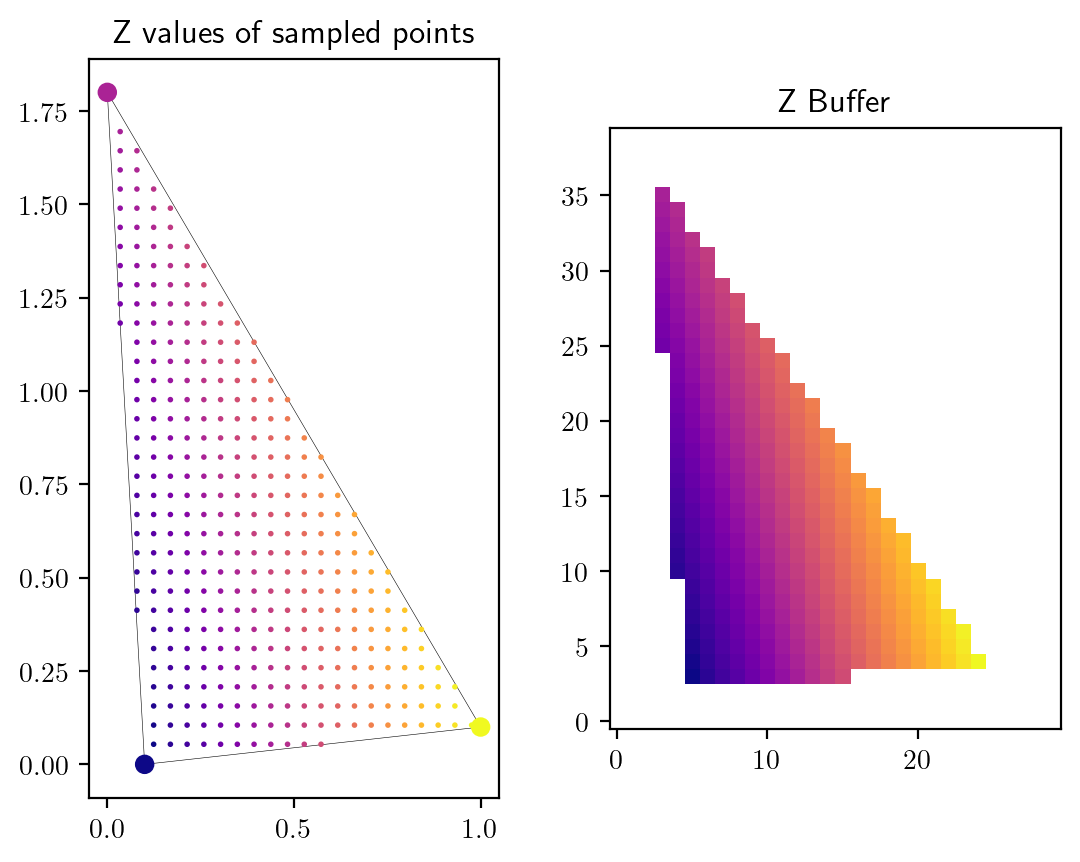

In [277]:
points = np.array([[.1, 0, .1],  [0, 1.8, .4], [1, .1, .9]])
tri = Delaunay(points[:,:2])

zb2 = Z_Buffer(left=-.1, right=1.9, bottom=-.1, top=1.2, buffer_width=40, buffer_height=30)

# Create coordinate grid for evaluating Z-buffer values
x_range = np.arange(30)
y_range = np.arange(40)
x, y = np.meshgrid(x_range, y_range)
xy = np.array((x.flatten(), y.flatten())).T
xy = np.apply_along_axis(zb2.index_to_coord, 1, xy)


b = tri.transform[0,:2].dot(np.transpose(xy - tri.transform[0,2]))
weights = np.c_[np.transpose(b), 1 - b.sum(axis=0)]

# Find ordering of points in triangle relative to original order
tri_points = tri.points[tri.simplices[0]]
u = np.argwhere(np.all(np.equal(points[0,:2], tri_points), axis=1))
v = np.argwhere(np.all(np.equal(points[1,:2], tri_points), axis=1))
w = np.argwhere(np.all(np.equal(points[2,:2], tri_points), axis=1))

weights = weights.T[np.array([u, v, w]).flatten()].T
z_values = np.dot(weights, points[:,2])

fig, ax = plt.subplots(1,2, facecolor=(1, 1, 1))
ax[0].triplot(points[:,0], points[:,1], tri.simplices, lw=.2, c='k')
ax[0].scatter(points[:,0], points[:,1], c=points[:,2], cmap='plasma')
x, y = xy[np.all(weights>0, axis=1).T].T
cs = z_values[np.all(weights>0, axis=1).T].T
ax[0].scatter(x, y, c=cs, s=1, cmap='plasma')
ax[0].axis('scaled')
ax[0].set_title("Z values of sampled points")
xi, yi = zb2.coord_to_index(np.array([x, y]).T).T.astype(np.int64)
zb2.buffer[xi, yi] = np.maximum(cs, zb2.buffer[xi, yi])
ax[1].imshow(zb2.buffer.T, origin='lower', cmap='plasma')
ax[1].axis('scaled')
ax[1].set_title("Z Buffer")
plt.show()

(22, 2)


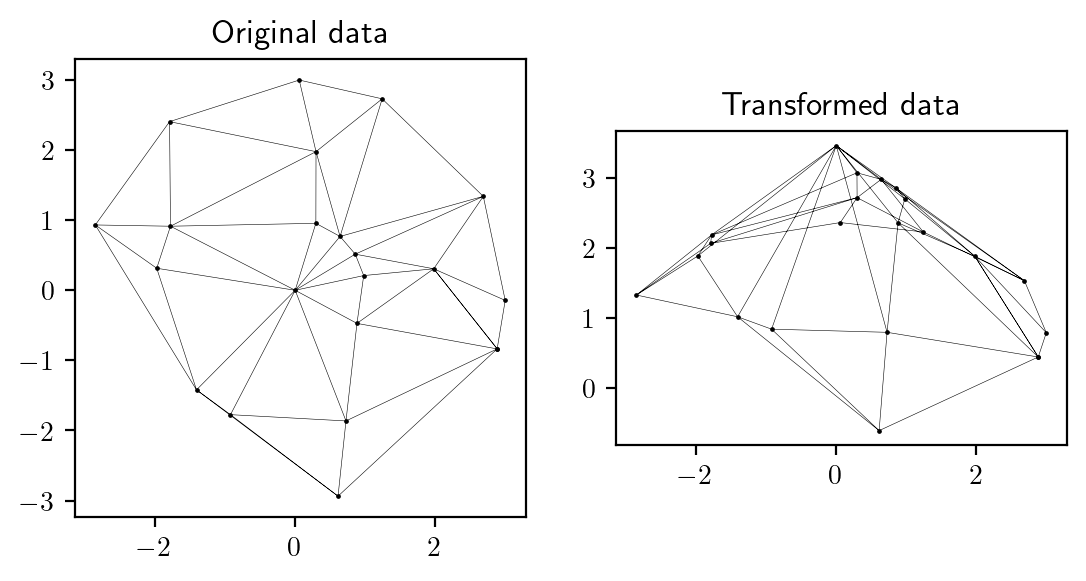

In [278]:
s1 = np.random.randn(9) * 2 * np.pi
s2 = np.random.randn(7) * 2 * np.pi
s3 = np.random.randn(5) * 2 * np.pi

c1 = 3*np.sin(s1), 3*np.cos(s1)
c2 = 2*np.sin(s2), 2*np.cos(s2)
c3 = np.sin(s3), np.cos(s3)

y1 = np.full(s1.shape[0], 1)
y2 = np.full(s2.shape[0], 2)
y3 = np.full(s3.shape[0], 3)

ys = np.hstack((y1, y2, y3, np.full(1,4)))
points = np.hstack((c1, c2, c3, np.zeros(2).reshape(-1,1))).T
print(points.shape)
tri_cone = Delaunay(points)

fig, ax = plt.subplots(1,2)

ax[0].triplot(points[:,0], points[:,1], tri_cone.simplices, lw=.2, c='k')
ax[0].scatter(points[:,0], points[:,1], s=.5, c='k')
ax[0].axis('scaled')
ax[0].set_title('Original data')

three = np.hstack((points, ys.reshape(-1,1)))
x_angle = -60
z_angle = 50
rx = R.from_euler('x', x_angle, degrees=True)
rz = R.from_euler('z', z_angle, degrees=True)
x, y, z = rx.apply(three).T
ax[1].triplot(x, y, tri_cone.simplices, lw=.2, c='k')
#print(x,y,z)
ax[1].scatter(x, y, s=.5, c='k')
ax[1].set_title('Transformed data')
ax[1].axis('scaled')

plt.show()

## Putting it all together

We now have all the tools to determine point occlusion. 

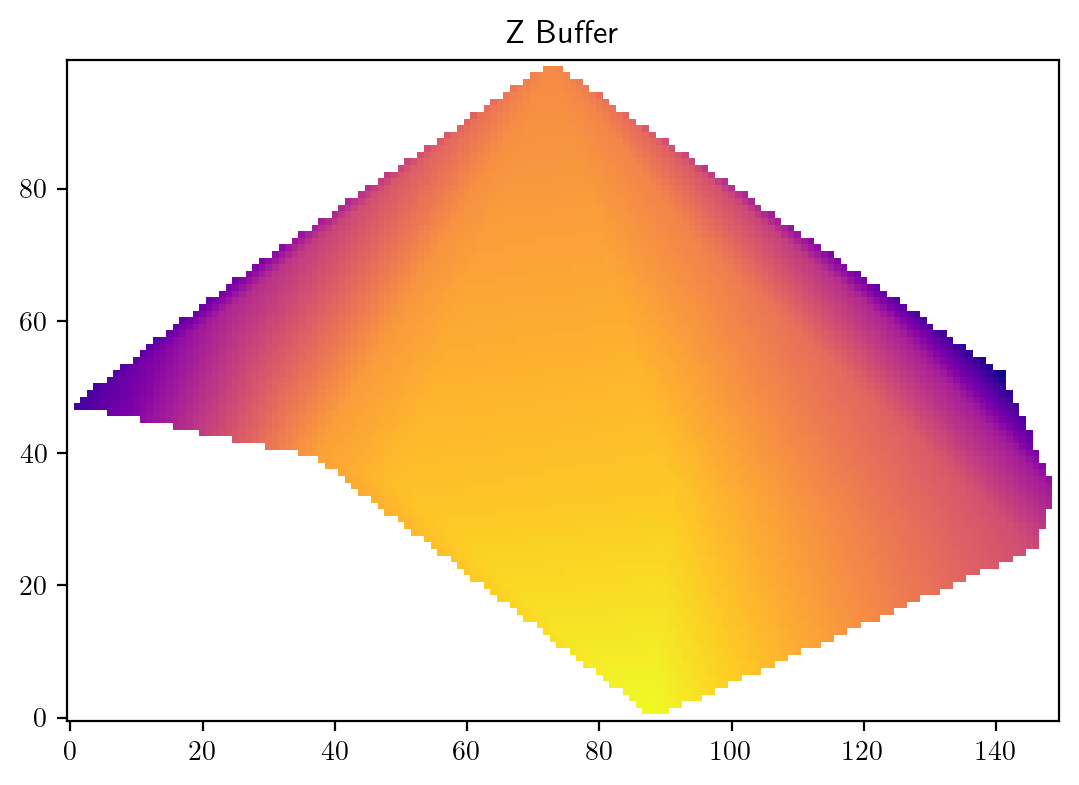

In [279]:
zb3 = Z_Buffer(np.min(y), np.max(y), np.min(x), np.max(x), 100, 150)

for i, t in enumerate(tri_cone.simplices):
    bottom, left = zb3.coord_to_index(np.array([np.min(x[t]), np.min(y[t])]))
    top, right = zb3.coord_to_index(np.array([np.max(x[t]), np.max(y[t])]))
    x_ind, y_ind = np.meshgrid(np.arange(bottom, top+1), np.arange(left, right+1))
    xy = zb3.index_to_coord(np.array((x_ind.flatten(), y_ind.flatten())).T)

    points = np.array([x[t], y[t]]).T
    single = Delaunay(points)

    b = single.transform[0,:2].dot(np.transpose(xy - single.transform[0,2]))
    weights = np.c_[np.transpose(b), 1 - b.sum(axis=0)]

    # Find ordering of points in triangle relative to original order
    tri_points = single.points[single.simplices[0]]

    u = np.argwhere(np.all(np.equal(points[0], tri_points), axis=1))
    v = np.argwhere(np.all(np.equal(points[1], tri_points), axis=1))
    w = np.argwhere(np.all(np.equal(points[2], tri_points), axis=1))

    weights = weights.T[np.array([u, v, w]).flatten()].T
    z_values = np.dot(weights, z[t])
    
    x_filtered, y_filtered = xy[np.all(weights>0, axis=1).T].T
    z_filtered = z_values[np.all(weights>0, axis=1).T].T
    xi, yi = zb3.coord_to_index(np.array([x_filtered, y_filtered]).T).T.astype(np.int64)
    zb3.buffer[xi, yi] = np.maximum(z_filtered, zb3.buffer[xi, yi])

plt.imshow(zb3.buffer.T, origin='lower', cmap='plasma')
plt.axis('scaled')
plt.title("Z Buffer")
plt.show()